# Neural Architecture Search (Basic)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/NAS_basic.ipynb)

In this tutorial we will learn the basics of neural architecture search (NAS). We will use artificial data generated from a polynomial function. Then, we will discover how to create a search space of neural architecture using a directed graph. Finally, we will see how to define the NAS settings and how to execute the search.



In [1]:
!pip install deephyper

Defaulting to user installation because normal site-packages is not writeable


<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

In [2]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

Defaulting to user installation because normal site-packages is not writeable


<div class="alert alert-info">
    
<b>Note</b>
    
The following environment variables can be used to avoid the logging of **some** Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [3]:
import os


os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(3)
os.environ["AUTOGRAPH_VERBOSITY"] = str(0)

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to detect if <b>GPU</b> devices are available on the current host. Therefore, this notebook will automatically adapt the parallel execution based on the resources available locally. However, this simple code will not detect the ressources from multiple nodes.
    
</div>

In [4]:
from tensorflow.python.client import device_lib


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]


n_gpus = len(get_available_gpus())
if n_gpus > 1:
    n_gpus -= 1
    
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

1 GPU is available.


## Loading the data

First, we will create the `load_data` function which loads and returns the
training and validation data. The `load_data` function generates data from
a function $f$ where $\mathbf{x} \in [a, b]^n$  such as $f(\mathbf{x}) = -\sum_{i=0}^{n-1} {x_i ^2}$:

In [5]:
import numpy as np

def load_data(verbose=0, dim=10, a=-50, b=50, prop=0.80, size=10000):
    rs = np.random.RandomState(2018)

    def polynome_2(x):
        return -sum([x_i ** 2 for x_i in x])

    d = b - a
    x = np.array([a + rs.random(dim) * d for _ in range(size)])
    y = np.array([[polynome_2(v)] for v in x])

    sep_index = int(prop * size)
    X_train = x[:sep_index]
    y_train = y[:sep_index]

    X_valid = x[sep_index:]
    y_valid = y[sep_index:]
    
    if verbose:
        print(f"X_train shape: {np.shape(X_train)}")
        print(f"y_train shape: {np.shape(y_train)}")
        print(f"X_valid shape: {np.shape(X_valid)}")
        print(f"y_valid shape: {np.shape(y_valid)}")
    return (X_train, y_train), (X_valid, y_valid)


_ = load_data(verbose=1)

X_train shape: (8000, 10)
y_train shape: (8000, 1)
X_valid shape: (2000, 10)
y_valid shape: (2000, 1)


## Define a neural architecture search space

Let us define the neural architecture search space. To do this we use a `KSearchSpace` class. We define the `ResNetMLPSpace` search space which is a sub-class of `KSearchSpace` where we have to implement a `build()` method which return itself. The `__init__` method is used to pass possible options of the search space such as the maximum number of layers `self.num_layers`.

The input nodes can be retrieved with `self.input_nodes` which is automatically built depending on the `input_shape`.

The search space is composed of `ConstantNode` and `VariableNode`. A `ConstantNode` defines a fixed operations whereas the `VariableNode` defines a list of possible operations (i.e., corresponds to a categorical decision variable). Operations can be defined directly from Keras Layers such as:

```python
Activation = operation(tf.keras.layers.Activation)
```

All nodes of the search space without outer edges are automatically assumed to be output nodes.

In [6]:
import collections

import tensorflow as tf

from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity


Activation = operation(tf.keras.layers.Activation)
Dense = operation(tf.keras.layers.Dense)
Dropout = operation(tf.keras.layers.Dropout)
Add = operation(tf.keras.layers.Add)
Flatten = operation(tf.keras.layers.Flatten)

ACTIVATIONS = [
    tf.keras.activations.elu,
    tf.keras.activations.gelu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.linear,
    tf.keras.activations.relu,
    tf.keras.activations.selu,
    tf.keras.activations.sigmoid,
    tf.keras.activations.softplus,
    tf.keras.activations.softsign,
    tf.keras.activations.swish,
    tf.keras.activations.tanh,
]


class ResNetMLPSpace(KSearchSpace):
    
    def __init__(self, input_shape, output_shape, seed=None, num_layers=3, mode="regression"):
        super().__init__(input_shape, output_shape, seed=seed)
        
        self.num_layers = num_layers
        assert mode in ["regression", "classification"]
        self.mode = mode
        
    def build(self):
        
        source = self.input_nodes[0]
        output_dim = self.output_shape[0]

        out_sub_graph = self.build_sub_graph(source, self.num_layers)

        if self.mode == "regression":
            output = ConstantNode(op=Dense(output_dim)) 
            self.connect(out_sub_graph, output)
        else:
            output = ConstantNode(
                op=Dense(output_dim, activation="softmax")
            )  # One-hot encoding
            self.connect(out_sub_graph, output)

        return self

    def build_sub_graph(self, input_, num_layers=3):
        source = prev_input = input_

        # look over skip connections within a range of the 3 previous nodes
        anchor_points = collections.deque([source], maxlen=3)

        for _ in range(self.num_layers):
            dense = VariableNode()
            self.add_dense_to_(dense)
            self.connect(prev_input, dense)
            x = dense

            dropout = VariableNode()
            self.add_dropout_to_(dropout)
            self.connect(x, dropout)
            x = dropout

            add = ConstantNode()
            add.set_op(AddByProjecting(self, [x], activation="relu"))

            for anchor in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, add)

            prev_input = add

            # ! for next iter
            anchor_points.append(prev_input)

        return prev_input

    def add_dense_to_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case
        for units in range(16, 16 * 16 + 1, 16):
            for activation in ACTIVATIONS:
                node.add_op(Dense(units=units, activation=activation))

    def add_dropout_to_(self, node):
        a, b = 1e-3, 0.4
        node.add_op(Identity())
        dropout_range = np.exp(np.linspace(np.log(a), np.log(b), 10))  #! NAS
        for rate in dropout_range:
            node.add_op(Dropout(rate))

A `KSearchSpace` as some useful methods such as:

* `space.sample(choice)` which returns a random model from the search space if `choice == None` or generate a model corresponding to the choice if not.
* `space.choices()` which returns the list of discrete dimensions corresponding to the search space.

Let us visualize a few randomly sampled neural architecture from this search space.

Choices:  [(0, 176), (0, 10), (0, 1), (0, 176), (0, 10), (0, 1), (0, 1), (0, 176), (0, 10), (0, 1), (0, 1), (0, 1)]


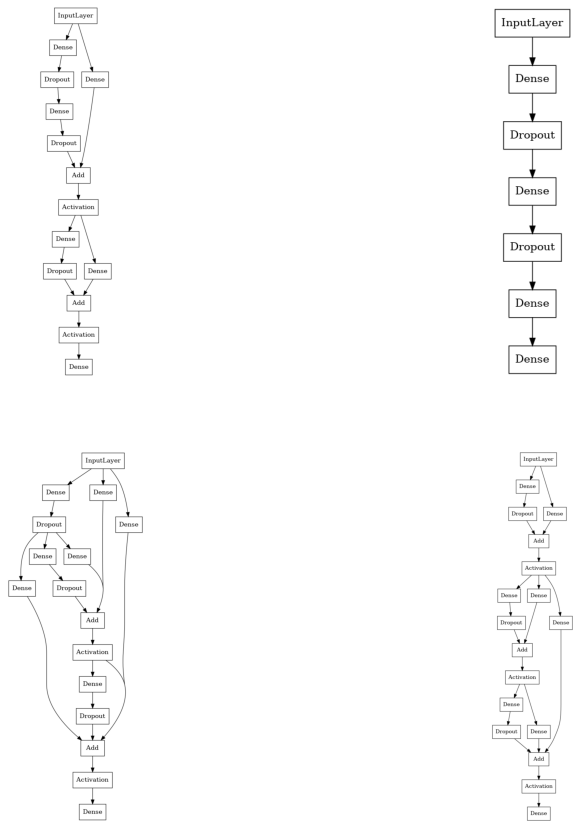

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

shapes = dict(input_shape=(10,), output_shape=(1,))
space = ResNetMLPSpace(**shapes).build()

print("Choices: ", space.choices())

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    model = space.sample()
    plot_model(model, "random_model.png", 
               show_shapes=False, show_layer_names=False) 
    image = mpimg.imread("random_model.png")   
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Create a problem instance

Let us define the neural architecture search problem.

In [8]:
from deephyper.problem import NaProblem
from deephyper.nas.preprocessing import minmaxstdscaler

# Create a Neural Architecture problem
problem = NaProblem()

# Link the load-data function
problem.load_data(load_data)

# The function passed to preprocessing has to return 
# a scikit-learn like preprocessor.
problem.preprocessing(minmaxstdscaler)

# Link the defined search space
problem.search_space(ResNetMLPSpace)

# Fixed hyperparameters for all trained models
problem.hyperparameters(
    batch_size=32,
    learning_rate=0.01,
    optimizer="adam",
    num_epochs=20,
    callbacks=dict(
        EarlyStopping=dict(
            monitor="val_r2", mode="max", verbose=0, patience=5
        )
    ),
)

# Define the optimized loss (it can also be a function)
problem.loss("mse")

# Define metrics to compute for each training and validation epoch
problem.metrics(["r2"])

# Define the maximised objective
problem.objective("val_r2__last")

problem

Problem is:
    - search space   : __main__.ResNetMLPSpace
    - data loading   : __main__.load_data
    - preprocessing  : deephyper.nas.preprocessing._base.minmaxstdscaler
    - hyperparameters: 
        * verbose: 0
        * batch_size: 32
        * learning_rate: 0.01
        * optimizer: adam
        * num_epochs: 20
        * callbacks: {'EarlyStopping': {'monitor': 'val_r2', 'mode': 'max', 'verbose': 0, 'patience': 5}}
    - loss           : mse
    - metrics        : 
        * r2
    - objective      : val_r2__last

Find more about `NaProblem` settings on the [Problem documentation](https://deephyper.readthedocs.io/en/latest/api/deephyper.problem.html).

<div class="alert alert-info">
    
<b>Tip</b>
    

Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_r2", mode="max", verbose=0, patience=5)
...
```
    
</div>

## Running the search

Create an `Evaluator` object using the `ray` backend to distribute the evaluation of the run-function. In neural architecture search DeepHyper provides the `run_base_trainer` function which automate the training process of a sampled model.

In [9]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback
from deephyper.nas.run import run_base_trainer


def get_evaluator(run_function):
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()]
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

evaluator_1 = get_evaluator(run_base_trainer)

2022-02-10 06:43:11,972	WARNING services.py:1748 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 8589807616 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7f58e0362880>], 'num_gpus': 1, 'num_gpus_per_task': 1}


<div class="alert alert-info">
    
<b>Tip</b> 
    
If executed locally, you can open the ray-dashboard at an address like <a>http://127.0.0.1:port</a> in a browser to monitor the CPU usage of the execution.
    
</div>

Finally, you can define a Random search called `Random` and link to it the defined `problem` and `evaluator`.

In [10]:
from deephyper.search.nas import Random


search = Random(problem, evaluator_1)

In [11]:
if os.path.exists("save/history"):
    histories = [os.path.join("save/history", f) for f in os.listdir("save/history/") if ".json" in f]
    for history in histories:
        os.remove(history)

results = search.search(10)

[00001] -- best objective: 0.96638 -- received objective: 0.96638
[00002] -- best objective: 0.96638 -- received objective: 0.78498
[00003] -- best objective: 0.98785 -- received objective: 0.98785
[00004] -- best objective: 0.98785 -- received objective: 0.97289
[00005] -- best objective: 0.98785 -- received objective: 0.97746
[00006] -- best objective: 0.98785 -- received objective: 0.95083
[00007] -- best objective: 0.98785 -- received objective: 0.94777
[00008] -- best objective: 0.98785 -- received objective: 0.97849
[00009] -- best objective: 0.98785 -- received objective: 0.92696
[00010] -- best objective: 0.98785 -- received objective: 0.96118


After the search is over, you will find the following files in your current folder:

```
results.csv
save/
```

Let us visualize the training of our models. First, we need to load the training history of each model which are located in `save/history`:

In [12]:
import os
import json


histories = [os.path.join("save/history", f) for f in os.listdir("save/history/") if ".json" in f]

for i, fpath in enumerate(histories):
    with open(fpath, "r") as fd:
        histories[i] = json.load(fd)
        
print(list(histories[0].keys()))

['n_parameters', 'training_time', 'loss', 'r2', 'val_loss', 'val_r2']


Text(0.5, 0, 'Epochs')

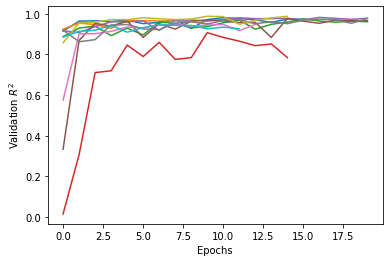

In [13]:
plt.figure()
plt.clf()

for h in histories:
    plt.plot(h["val_r2"])

plt.ylabel("Validation $R^2$")
plt.xlabel("Epochs")


Once the search is over, a file named `results.csv` is saved in the current directory. The same dataframe is returned by the `search.search(...)` call. It contains the configurations evaluated during the search and their corresponding `objective` value (i.e, validation accuracy), `duration` of computation and time of computation with `elapsed_sec`. Each neural architecture is embedded as a list of discrete decision variables called `arch_seq`.

In [14]:
results

,arch_seq,id,objective,elapsed_sec,duration
0,"[117, 0, 1, 83, 0, 0, 0, 115, 2, 1, 0, 1]",1,0.966377,16.005563,14.461492
1,"[83, 5, 0, 173, 3, 0, 1, 114, 10, 0, 0, 0]",2,0.784980,23.184479,7.177167
2,"[131, 1, 1, 9, 2, 1, 1, 97, 3, 0, 0, 1]",3,0.987855,31.552139,8.366397
3,"[166, 4, 1, 16, 8, 1, 0, 142, 2, 0, 1, 0]",4,0.972885,40.329282,8.776129
4,"[86, 5, 0, 49, 6, 1, 0, 41, 1, 0, 0, 1]",5,0.977457,50.230067,9.899308
5,"[38, 5, 1, 135, 0, 0, 1, 152, 1, 1, 0, 0]",6,0.950827,55.772317,5.540768
6,"[73, 9, 1, 17, 8, 1, 1, 96, 5, 1, 0, 1]",7,0.947772,63.223380,7.449811
7,"[75, 6, 1, 60, 6, 0, 1, 155, 5, 1, 1, 1]",8,0.978486,74.672457,11.447643
8,"[117, 2, 1, 121, 1, 1, 1, 127, 9, 0, 0, 0]",9,0.926956,80.926041,6.252307
9,"[136, 4, 1, 78, 5, 1, 0, 129, 5, 0, 1, 0]",10,0.961181,91.371069,10.443996


The `deephyper-analytics` command line is a way of analyzing this type of file. For example, we want to output the best configuration we can use the `topk` functionnality.

In [15]:
!deephyper-analytics topk results.csv -k 3

'0':
  arch_seq: '[131, 1, 1, 9, 2, 1, 1, 97, 3, 0, 0, 1]'
  duration: 8.3663973808
  elapsed_sec: 31.5521390438
  id: 3
  objective: 0.987854898
'1':
  arch_seq: '[75, 6, 1, 60, 6, 0, 1, 155, 5, 1, 1, 1]'
  duration: 11.4476428032
  elapsed_sec: 74.6724574566
  id: 8
  objective: 0.9784857631
'2':
  arch_seq: '[86, 5, 0, 49, 6, 1, 0, 41, 1, 0, 0, 1]'
  duration: 9.8993084431
  elapsed_sec: 50.2300672531
  id: 5
  objective: 0.9774566293



Where each architecture is described as a vector of scalar values named arch_seq. In fact, each of this scalar values represents chosen operations for the variable nodes of our search space. 

## Testing the best configuration

We can visualize the architecture of the best configuration:

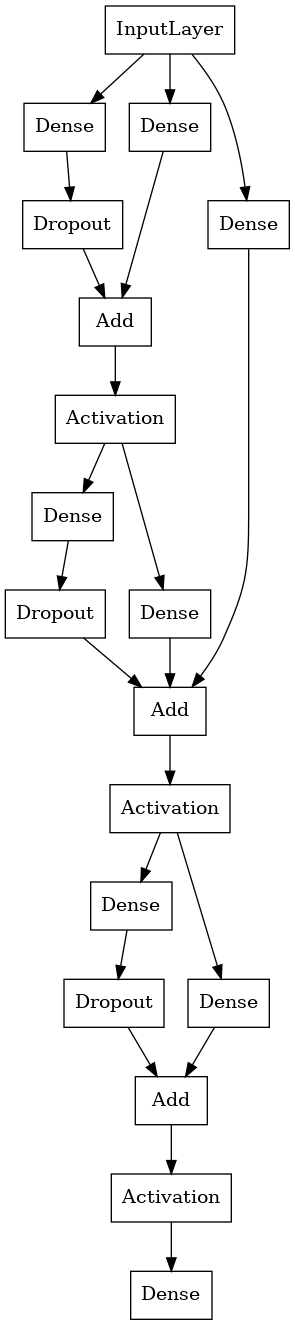

In [16]:
best_config = results.iloc[results.objective.argmax()][:-2].to_dict()
arch_seq = json.loads(best_config["arch_seq"])
model = space.sample(arch_seq)
plot_model(model, show_shapes=False, show_layer_names=False) 